# Задача 6
### Плюснин Павел 578 / plyusnin.pa@phystech.edu
Изучить поведение FDR для эксперимента из лекции. Рассмотреть случаи, когда количество объектов m варьируется от 200 от 100000. Калибруемые параметры: m, m0, alpha  

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import scipy.stats as st
import seaborn as sns
import pandas as pd

Функция multiTest возвращает количество неверно и верно отвергнутых H_0 соответственно

In [2]:
def p_values_calc(X, mu=0):
    """Подсчитывает p_values"""
    p_values = []
    for index, x in enumerate(X):
        p_value = st.ttest_1samp(x, mu)[1]
        p_values.append(p_value)
    return p_values

def multiTests(X, m0, method=None, alpha = 0.05, mu=0):
    """Возвращает количество неверно и верно отвергнутых H_0 соответственно"""
    p_values = p_values_calc(X, mu)
    if method:
        p_values = multipletests(p_values, alpha, method)[1]
    rejected = np.array(p_values) <= alpha
    return rejected[:m0].sum(), rejected[m0:].sum()

def FDR(V, S):
    R = V + S
    return V / max(R, 1)

Приступаем к экспериментам:  
Напишем универсальную функцию, которая для фиксированных двух параметров будет варьировать третий параметр в заданных пределах и возвращает соответствующие значения FDR

In [3]:
defaults = {"m":2000, "m0":1000, "alpha":0.05}
limits = {"m":(200, 100000), "m0":(0, 100000), "alpha":(1e-5, 1)}
fixed = set(["m", "alpha"])
from tqdm import tqdm_notebook as tqdm
from statsmodels.stats.multitest import multipletests

def tests(fixed, method, n_tests=30, defaults=defaults, limits=limits, n_objects=20):
    rs = np.random.RandomState(42)
    all_params = set(["m", "alpha", "m0"])            #выделяем переменный параметр
    param = list(all_params - fixed)[0]
    
    m = defaults["m"]
    m0 = defaults["m0"]
    alpha = defaults["alpha"]
    
    if param == "alpha":
        param_range = limits["alpha"]
    elif param == "m":
        m0 = defaults["m0"]
        param_range = ( max(limits[param][0], m0), max(limits[param][1], m0) )
    elif param == "m0":
        m = defaults["m"]
        param_range = ( min(limits[param][0], m), min(limits[param][1], m) )
    else:
        raise Exception("WTF?! Param should be in {m, m0, alpha}")
    
    if param == "alpha":
        param_range = np.linspace(*param_range, n_tests)
    else:
        param_range = list(map(int, np.linspace(*param_range, n_tests)))   #получили range для переменного параметра,
                                                                        #остальные параметры - зафиксированы
    FDRs = []
    
    for fixed_param in fixed:
        print(fixed_param, "==", defaults[fixed_param])
    print(param, "in range", param_range)
    
    for param_value in tqdm(param_range):
        if param == "alpha":
            alpha = param_value
        elif param == "m":
            m = param_value
        else:
            m0 = param_value
        
        
        X = rs.randn(m, n_objects)
        X[m0:] += 1
        
        FDRs.append(FDR(*multiTests(X, m0, method, alpha, mu=0)))
    return param_range, FDRs

alpha == 0.05
m == 2000
m0 in range [0, 68, 137, 206, 275, 344, 413, 482, 551, 620, 689, 758, 827, 896, 965, 1034, 1103, 1172, 1241, 1310, 1379, 1448, 1517, 1586, 1655, 1724, 1793, 1862, 1931, 2000]



alpha == 0.05
m == 2000
m0 in range [0, 68, 137, 206, 275, 344, 413, 482, 551, 620, 689, 758, 827, 896, 965, 1034, 1103, 1172, 1241, 1310, 1379, 1448, 1517, 1586, 1655, 1724, 1793, 1862, 1931, 2000]


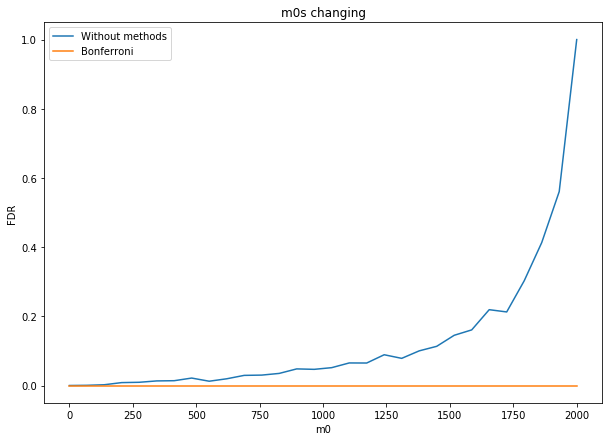

In [4]:
m0s, FDRs = tests(fixed={"m", "alpha"}, method=None)
m0sB, FDRsB = tests(fixed={"m", "alpha"}, method="bonferroni")
plt.figure(figsize=(10,7))
plt.plot(m0s, FDRs)
plt.plot(m0sB, FDRsB)
plt.title("m0s changing")
plt.xlabel("m0")
plt.ylabel("FDR")
plt.legend(["Without methods", "Bonferroni"])

Text(0,0.5,'FDR')

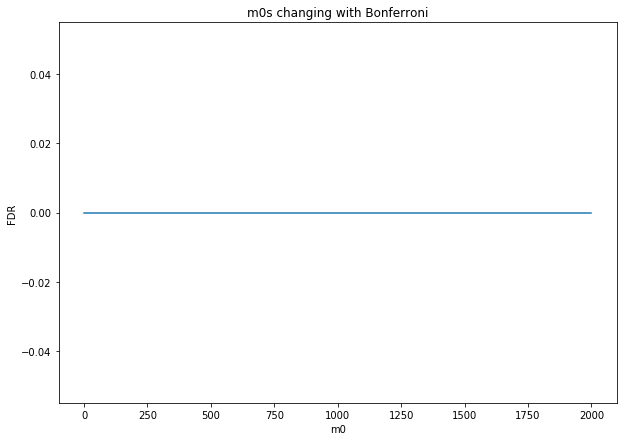

In [5]:
plt.figure(figsize=(10,7))
plt.plot(m0sB, FDRsB)
plt.title("m0s changing with Bonferroni")
plt.xlabel("m0")
plt.ylabel("FDR")

При меняющемся m0 видим, что без поправок FDR монотонно растет. При малых отношениях $m_0/m \leq 0.08$ FDR мало меняется - остается в пределах 0.2. В дальнейшем, взрывообразно растет. При использовании поправки Бонферонни FDR не меняется

alpha == 0.05
m0 == 200
m in range [200, 3641, 7082, 10524, 13965, 17406, 20848, 24289, 27731, 31172, 34613, 38055, 41496, 44937, 48379, 51820, 55262, 58703, 62144, 65586, 69027, 72468, 75910, 79351, 82793, 86234, 89675, 93117, 96558, 100000]



alpha == 0.05
m0 == 200
m in range [200, 3641, 7082, 10524, 13965, 17406, 20848, 24289, 27731, 31172, 34613, 38055, 41496, 44937, 48379, 51820, 55262, 58703, 62144, 65586, 69027, 72468, 75910, 79351, 82793, 86234, 89675, 93117, 96558, 100000]


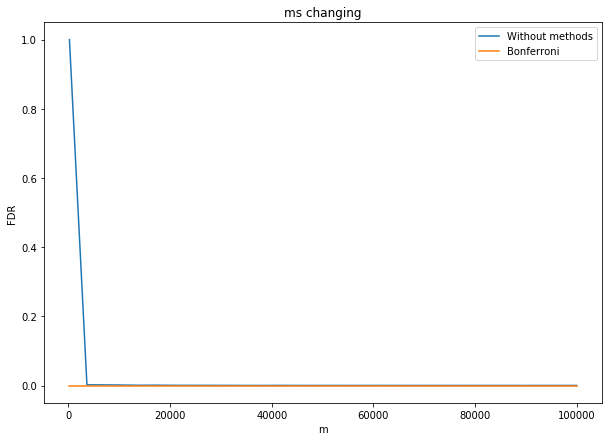

In [6]:
ms, FDRs = tests(fixed={"m0", "alpha"}, defaults = {"m":200, "m0":200, "alpha":0.05}, method=None)
msB, FDRsB = tests(fixed={"m0", "alpha"}, defaults = {"m":200, "m0":200, "alpha":0.05}, method="bonferroni")
plt.figure(figsize=(10,7))
plt.plot(ms, FDRs)
plt.plot(msB, FDRsB)
plt.title("ms changing")
plt.xlabel("m")
plt.ylabel("FDR")
plt.legend(["Without methods", "Bonferroni"])

Собственно, из предыдущего эксперимента очевиден исход и этого: при увеличении m, будет уменьшаться $m0/m$ - получим стремительное падение FDR в начале, а далее - пологий склон. При использовании поправки FDR постоянен. Что и наблюдаем

alpha == 0.05
m0 == 200
m in range [200, 227, 255, 282, 310, 337, 365, 393, 420, 448, 475, 503, 531, 558, 586, 613, 641, 668, 696, 724, 751, 779, 806, 834, 862, 889, 917, 944, 972, 1000]



alpha == 0.05
m0 == 200
m in range [200, 227, 255, 282, 310, 337, 365, 393, 420, 448, 475, 503, 531, 558, 586, 613, 641, 668, 696, 724, 751, 779, 806, 834, 862, 889, 917, 944, 972, 1000]


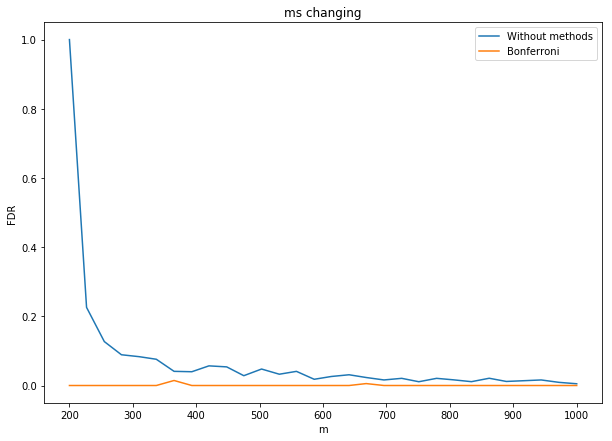

In [7]:
ms, FDRs = tests(fixed={"m0", "alpha"}, defaults = {"m":200, "m0":200, "alpha":0.05},\
                 limits = {"m":(200, 1000), "m0":(0, 100000), "alpha":(1e-5, 1)}, method=None)
msB, FDRsB = tests(fixed={"m0", "alpha"}, defaults = {"m":200, "m0":200, "alpha":0.05},\
                 limits = {"m":(200, 1000), "m0":(0, 100000), "alpha":(1e-5, 1)}, method="bonferroni")

plt.figure(figsize=(10,7))
plt.plot(ms, FDRs)
plt.plot(msB, FDRsB)
plt.title("ms changing")
plt.xlabel("m")
plt.ylabel("FDR")
plt.legend(["Without methods", "Bonferroni"])

Text(0,0.5,'FDR')

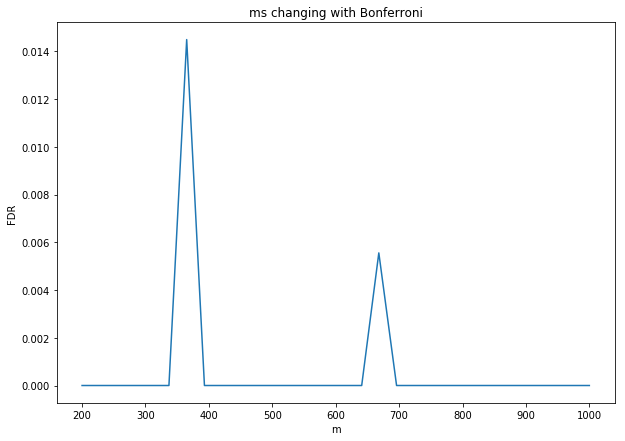

In [8]:
plt.figure(figsize=(10,7))
plt.plot(msB, FDRsB)
plt.title("ms changing with Bonferroni")
plt.xlabel("m")
plt.ylabel("FDR")

Здесь мы пересчитали то же самое на самом интересном участке - в начале, при больших $m0/m$. При использовании поправки Бонферрони иногда случаются незначительные выбросы, ничего страшного

m == 2000
m0 == 1000
alpha in range [1.00000000e-05 3.44924138e-02 6.89748276e-02 1.03457241e-01
 1.37939655e-01 1.72422069e-01 2.06904483e-01 2.41386897e-01
 2.75869310e-01 3.10351724e-01 3.44834138e-01 3.79316552e-01
 4.13798966e-01 4.48281379e-01 4.82763793e-01 5.17246207e-01
 5.51728621e-01 5.86211034e-01 6.20693448e-01 6.55175862e-01
 6.89658276e-01 7.24140690e-01 7.58623103e-01 7.93105517e-01
 8.27587931e-01 8.62070345e-01 8.96552759e-01 9.31035172e-01
 9.65517586e-01 1.00000000e+00]



m == 2000
m0 == 1000
alpha in range [1.00000000e-05 3.44924138e-02 6.89748276e-02 1.03457241e-01
 1.37939655e-01 1.72422069e-01 2.06904483e-01 2.41386897e-01
 2.75869310e-01 3.10351724e-01 3.44834138e-01 3.79316552e-01
 4.13798966e-01 4.48281379e-01 4.82763793e-01 5.17246207e-01
 5.51728621e-01 5.86211034e-01 6.20693448e-01 6.55175862e-01
 6.89658276e-01 7.24140690e-01 7.58623103e-01 7.93105517e-01
 8.27587931e-01 8.62070345e-01 8.96552759e-01 9.31035172e-01
 9.65517586e-01 1.00000000e+00]


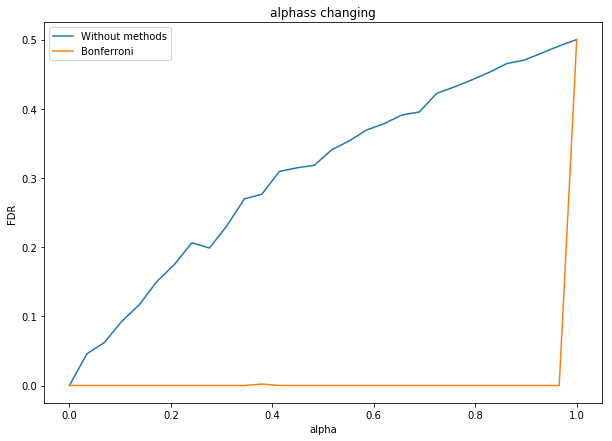

In [9]:
alphas, FDRs = tests(fixed={"m", "m0"}, method=None)
alphasB, FDRsB = tests(fixed={"m", "m0"}, method="bonferroni")
plt.figure(figsize=(10,7))
plt.plot(alphas, FDRs)
plt.plot(alphasB, FDRsB)
plt.title("alphass changing")
plt.xlabel("alpha")
plt.ylabel("FDR")
plt.legend(["Without methods", "Bonferroni"])

Text(0,0.5,'FDR')

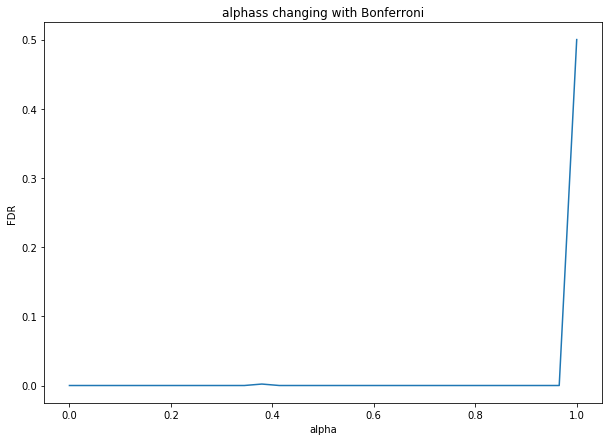

In [10]:
plt.figure(figsize=(10,7))
plt.plot(alphasB, FDRsB)
plt.title("alphass changing with Bonferroni")
plt.xlabel("alpha")
plt.ylabel("FDR")

При росте alpha наблюдаем рост и FDR. При использовании поправки, FDR остается константым (при альфа = 1, и FDR=1, что логично) 